In [1]:
import shutil
import os

# Remove the existing directory if it exists
# useful during development when testing updates
if os.path.exists('shor_eecs298'):
    shutil.rmtree('shor_eecs298')

!git clone https://github.com/radubach/shor_eecs298.git --depth 1
%cd shor_eecs298
import sys
sys.path.append('./src')

Cloning into 'shor_eecs298'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 16 (delta 1), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.80 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/shor_eecs298


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=a10f70d2d7653f6d8719ef3d790e34b50be249c31d775a4ec798009a9aa9d896
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [3]:
from utils import c_amod15, qft_dagger, qpe_mod15
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit_aer import AerSimulator
import pandas as pd
from fractions import Fraction
from math import gcd

n_count = 8
N = 15
a = 7

# Standard Computing example
N = 15
a = 7

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

def modular_exp_function(x: int, a: int = 7, N: int = 15) -> int:
    """
    Computes f(x) = a^x mod N

    Args:
        x: The exponent (control register value)
        a: Base number (default 7)
        N: Modulus (default 15)

    Returns:
        Result of a^x mod N
    """
    return pow(a, x, N)

def create_registers(max_value: int = 255, a: int = 7, N: int = 15) -> Tuple[List[int], List[int]]:
    """
    Creates control and output registers for classical demonstration

    Args:
        max_value: Maximum value for control register (default 255 for 8 qubits)
        a: Base number for modular exponentiation
        N: Modulus

    Returns:
        Tuple of (control_register, output_register)
    """
    # Control register: all possible input values
    control_register = list(range(max_value + 1))

    # Output register: apply f(x) = a^x mod N to each control value
    output_register = [modular_exp_function(x, a, N) for x in control_register]

    return control_register, output_register

def plot_modular_exponentiation(control_reg: List[int], output_reg: List[int],
                               a: int = 7, N: int = 15, show_period: int = 20):
    """
    Plots the control vs output registers to visualize periodicity

    Args:
        control_reg: List of control register values
        output_reg: List of output register values
        a: Base number
        N: Modulus
        show_period: How many x values to show in detail (for clarity)
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Full range (0-255)
    ax1.scatter(control_reg, output_reg, alpha=0.6, s=2)
    ax1.set_xlabel('Control Register (x)')
    ax1.set_ylabel('Output Register (7^x mod 15)')
    ax1.set_title(f'Full Range: f(x) = {a}^x mod {N} for x ∈ [0, 255]')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.5, N-0.5)

    # Add horizontal lines to show possible output values
    for i in range(N):
        ax1.axhline(y=i, color='red', alpha=0.2, linestyle='--')

    # Plot 2: Zoomed in view to show periodicity clearly
    zoom_control = control_reg[:show_period]
    zoom_output = output_reg[:show_period]

    ax2.plot(zoom_control, zoom_output, 'bo-', markersize=8, linewidth=2)
    ax2.set_xlabel('Control Register (x)')
    ax2.set_ylabel('Output Register (7^x mod 15)')
    ax2.set_title(f'Detailed View: f(x) = {a}^x mod {N} for x ∈ [0, {show_period-1}] - Shows Period = 4')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-0.5, N-0.5)
    ax2.set_xticks(range(show_period))

    # Highlight the period
    for i in range(0, show_period, 4):
        ax2.axvline(x=i, color='red', alpha=0.5, linestyle='--',
                   label='Period boundaries' if i == 0 else "")

    # Add text annotations for the first few values
    for i in range(min(12, show_period)):
        ax2.annotate(f'{zoom_output[i]}',
                    (i, zoom_output[i]),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center', fontsize=10)

    ax2.legend()
    plt.tight_layout()
    plt.show()

def analyze_periodicity(output_reg: List[int], max_check: int = 50) -> None:
    """
    Analyzes and prints the periodic pattern in the output register

    Args:
        output_reg: List of output register values
        max_check: Maximum number of values to analyze
    """
    print("=== PERIODICITY ANALYSIS ===")
    print("First 20 values of f(x) = 7^x mod 15:")

    for i in range(min(20, len(output_reg))):
        print(f"f({i:2d}) = 7^{i:2d} mod 15 = {output_reg[i]:2d}")

    print("\n=== PERIOD DETECTION ===")

    # Find the period by looking for when the pattern repeats
    first_val = output_reg[0]
    period_candidates = []

    for p in range(1, min(max_check, len(output_reg))):
        if output_reg[p] == first_val:
            # Check if this is truly a period
            is_period = True
            check_length = min(p * 3, len(output_reg) - p)  # Check 3 periods ahead

            for i in range(check_length):
                if output_reg[i] != output_reg[i + p]:
                    is_period = False
                    break

            if is_period:
                period_candidates.append(p)

    if period_candidates:
        period = min(period_candidates)  # Smallest period
        print(f"Period found: {period}")
        print(f"Pattern: {output_reg[:period]} repeats every {period} steps")

        # Verify the period
        print(f"\nVerification: 7^{period} mod 15 = {pow(7, period, 15)}")
        if pow(7, period, 15) == 1:
            print("✓ This confirms the order of 7 modulo 15 is", period)
        else:
            print("✗ This is not the correct order")
    else:
        print("No clear period found in the range checked")



In [5]:
# Create the registers
control_register, output_register = create_registers(max_value=255, a=7, N=15)

In [6]:
analyze_periodicity(output_register)
print()

=== PERIODICITY ANALYSIS ===
First 20 values of f(x) = 7^x mod 15:
f( 0) = 7^ 0 mod 15 =  1
f( 1) = 7^ 1 mod 15 =  7
f( 2) = 7^ 2 mod 15 =  4
f( 3) = 7^ 3 mod 15 = 13
f( 4) = 7^ 4 mod 15 =  1
f( 5) = 7^ 5 mod 15 =  7
f( 6) = 7^ 6 mod 15 =  4
f( 7) = 7^ 7 mod 15 = 13
f( 8) = 7^ 8 mod 15 =  1
f( 9) = 7^ 9 mod 15 =  7
f(10) = 7^10 mod 15 =  4
f(11) = 7^11 mod 15 = 13
f(12) = 7^12 mod 15 =  1
f(13) = 7^13 mod 15 =  7
f(14) = 7^14 mod 15 =  4
f(15) = 7^15 mod 15 = 13
f(16) = 7^16 mod 15 =  1
f(17) = 7^17 mod 15 =  7
f(18) = 7^18 mod 15 =  4
f(19) = 7^19 mod 15 = 13

=== PERIOD DETECTION ===
Period found: 4
Pattern: [1, 7, 4, 13] repeats every 4 steps

Verification: 7^4 mod 15 = 1
✓ This confirms the order of 7 modulo 15 is 4



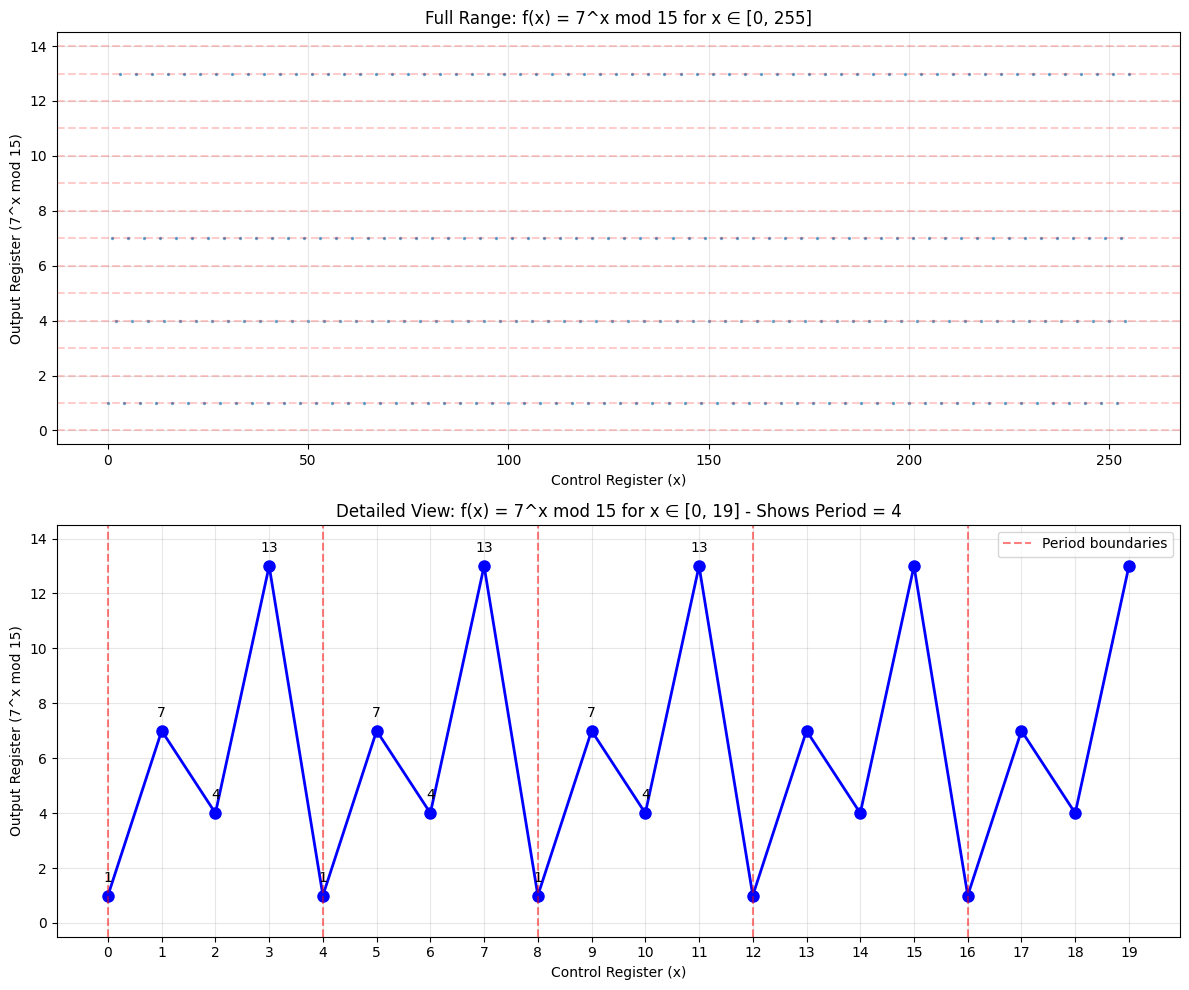

In [7]:
plot_modular_exponentiation(control_register, output_register, a=7, N=15)

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from typing import List, Tuple

def fourier_analysis(output_reg: List[int], control_reg: List[int],
                    a: int = 7, N: int = 15) -> None:
    """
    Applies Fourier transform to the output register to detect periodicity
    This demonstrates what the quantum Fourier transform does!

    Args:
        output_reg: List of output register values (7^x mod 15)
        control_reg: List of control register values (x)
        a: Base number
        N: Modulus
    """
    # Convert to numpy arrays
    signal = np.array(output_reg, dtype=float)
    n_samples = len(signal)

    # Apply FFT
    fft_result = fft(signal)
    frequencies = fftfreq(n_samples, d=1.0)  # d=1 means unit spacing

    # Calculate magnitude spectrum
    magnitude = np.abs(fft_result)

    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Original signal (first 40 points for clarity)
    zoom_range = min(40, len(control_reg))
    ax1.plot(control_reg[:zoom_range], output_reg[:zoom_range], 'bo-', markersize=6)
    ax1.set_xlabel('x (Control Register)')
    ax1.set_ylabel('f(x) = 7^x mod 15')
    ax1.set_title('Original Signal: Periodic Pattern')
    ax1.grid(True, alpha=0.3)

    # Highlight the period
    for i in range(0, zoom_range, 4):
        ax1.axvline(x=i, color='red', alpha=0.5, linestyle='--')
    ax1.text(0.02, 0.95, 'Period = 4', transform=ax1.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    # Plot 2: Full signal (first 64 points)
    full_range = min(64, len(control_reg))
    ax2.plot(control_reg[:full_range], output_reg[:full_range], 'g-', alpha=0.7)
    ax2.set_xlabel('x (Control Register)')
    ax2.set_ylabel('f(x) = 7^x mod 15')
    ax2.set_title('Extended View: Shows Multiple Periods')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Magnitude spectrum (frequency domain)
    # Only show positive frequencies and zoom in on relevant range
    half_n = n_samples // 2
    ax3.plot(frequencies[:half_n], magnitude[:half_n], 'r-', linewidth=2)
    ax3.set_xlabel('Frequency (cycles per sample)')
    ax3.set_ylabel('Magnitude')
    ax3.set_title('Fourier Transform: Frequency Peaks Reveal Period')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 0.5)  # Zoom in on relevant frequencies

    # Mark the expected peak at frequency = 1/4 = 0.25
    expected_freq = 1/4
    ax3.axvline(x=expected_freq, color='blue', linestyle='--', linewidth=2,
                label=f'Expected peak at 1/4 = {expected_freq}')
    ax3.legend()

    # Plot 4: Zoomed frequency spectrum around the main peak
    ax4.plot(frequencies[:half_n], magnitude[:half_n], 'r-', linewidth=2)
    ax4.set_xlabel('Frequency (cycles per sample)')
    ax4.set_ylabel('Magnitude')
    ax4.set_title('Zoomed Frequency Spectrum')
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 0.5)
    ax4.set_ylim(0, np.max(magnitude[:half_n]) * 0.3)  # Zoom in on smaller peaks

    # Mark important frequencies
    ax4.axvline(x=1/4, color='blue', linestyle='--', linewidth=2, label='1/4 (period=4)')
    ax4.axvline(x=1/2, color='green', linestyle='--', linewidth=2, label='1/2 (period=2)')
    ax4.axvline(x=1/1, color='orange', linestyle='--', linewidth=2, label='1/1 (period=1)')
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # Print analysis
    print("=== FOURIER TRANSFORM ANALYSIS ===")

    # Find the strongest peaks
    peak_threshold = np.max(magnitude) * 0.1  # 10% of max magnitude
    peak_indices = np.where(magnitude[:half_n] > peak_threshold)[0]
    peak_frequencies = frequencies[peak_indices]
    peak_magnitudes = magnitude[peak_indices]

    print("Significant frequency peaks found:")
    for freq, mag in zip(peak_frequencies, peak_magnitudes):
        if freq > 0:  # Skip DC component
            period = 1/freq if freq != 0 else float('inf')
            print(f"  Frequency: {freq:.4f} → Period: {period:.2f} → Magnitude: {mag:.1f}")

    print(f"\nExpected: Frequency = 1/4 = 0.25 (since period = 4)")
    print(f"This corresponds to the order r = 4 in Shor's algorithm")

def quantum_fourier_analogy(control_reg: List[int], output_reg: List[int], max_check: int = 50) -> None:
    """
    Explains how this classical FFT relates to the quantum Fourier transform
    """
    print("\n" + "="*60)
    print("=== QUANTUM FOURIER TRANSFORM ANALOGY ===")
    print("="*60)

    print("\n🔍 WHAT WE JUST SAW:")
    print("1. Classical FFT detected frequency peaks that reveal the period")
    print("2. The peak at frequency 1/4 tells us the period is 4")
    print("3. This is exactly what the quantum QFT does!")

    print("\n⚛️  IN THE QUANTUM VERSION:")
    print("• Control register is in SUPERPOSITION: (1/√256) Σ |x⟩")
    print("• Target register is ENTANGLED: Σ |x⟩|7^x mod 15⟩")
    print("• Inverse QFT on control register detects the same frequency peaks")
    print("• Measurement gives y-values near multiples of 256/4 = 64")

    print("\n📊 CLASSICAL vs QUANTUM:")
    print("CLASSICAL: We computed all 256 values of 7^x mod 15 explicitly")
    print("QUANTUM:   All 256 calculations happen simultaneously in superposition!")
    print("BOTH:      Use Fourier analysis to find the period r = 4")

    print("\n🎯 THE QUANTUM ADVANTAGE:")
    print("• Classical: O(2^n) time to compute all values")
    print("• Quantum:  O(n³) time using quantum circuits + QFT")
    print("• For large numbers: Exponential speedup!")

    # Show what the quantum measurements would look like
    print("\n📏 QUANTUM MEASUREMENT PREDICTIONS:")
    m = 8  # size of control register
    print(f"With {m}-qubit control register (0-255), expect peaks near:")
    for s in range(4):  # s = 0,1,2,3 for period r=4
        y_expected = s * (2**m) // 4
        print(f"  y ≈ {y_expected} (from s={s}, y = s×2^m/r = {s}×256/4)")

    print(f"\nClassical post-processing:")
    print(f"  y=64  → 64/256 = 1/4 → denominator = 4 ✓")
    print(f"  y=128 → 128/256 = 1/2 → denominator = 2 (divides 4)")
    print(f"  y=192 → 192/256 = 3/4 → denominator = 4 ✓")
    """
    Analyzes and prints the periodic pattern in the output register

    Args:
        output_reg: List of output register values
        max_check: Maximum number of values to analyze
    """
    print("=== PERIODICITY ANALYSIS ===")
    print("First 20 values of f(x) = 7^x mod 15:")

    for i in range(min(20, len(output_reg))):
        print(f"f({i:2d}) = 7^{i:2d} mod 15 = {output_reg[i]:2d}")

    print("\n=== PERIOD DETECTION ===")

    # Find the period by looking for when the pattern repeats
    first_val = output_reg[0]
    period_candidates = []

    for p in range(1, min(max_check, len(output_reg))):
        if output_reg[p] == first_val:
            # Check if this is truly a period
            is_period = True
            check_length = min(p * 3, len(output_reg) - p)  # Check 3 periods ahead

            for i in range(check_length):
                if output_reg[i] != output_reg[i + p]:
                    is_period = False
                    break

            if is_period:
                period_candidates.append(p)

    if period_candidates:
        period = min(period_candidates)  # Smallest period
        print(f"Period found: {period}")
        print(f"Pattern: {output_reg[:period]} repeats every {period} steps")

        # Verify the period
        print(f"\nVerification: 7^{period} mod 15 = {pow(7, period, 15)}")
        if pow(7, period, 15) == 1:
            print("✓ This confirms the order of 7 modulo 15 is", period)
        else:
            print("✗ This is not the correct order")
    else:
        print("No clear period found in the range checked")

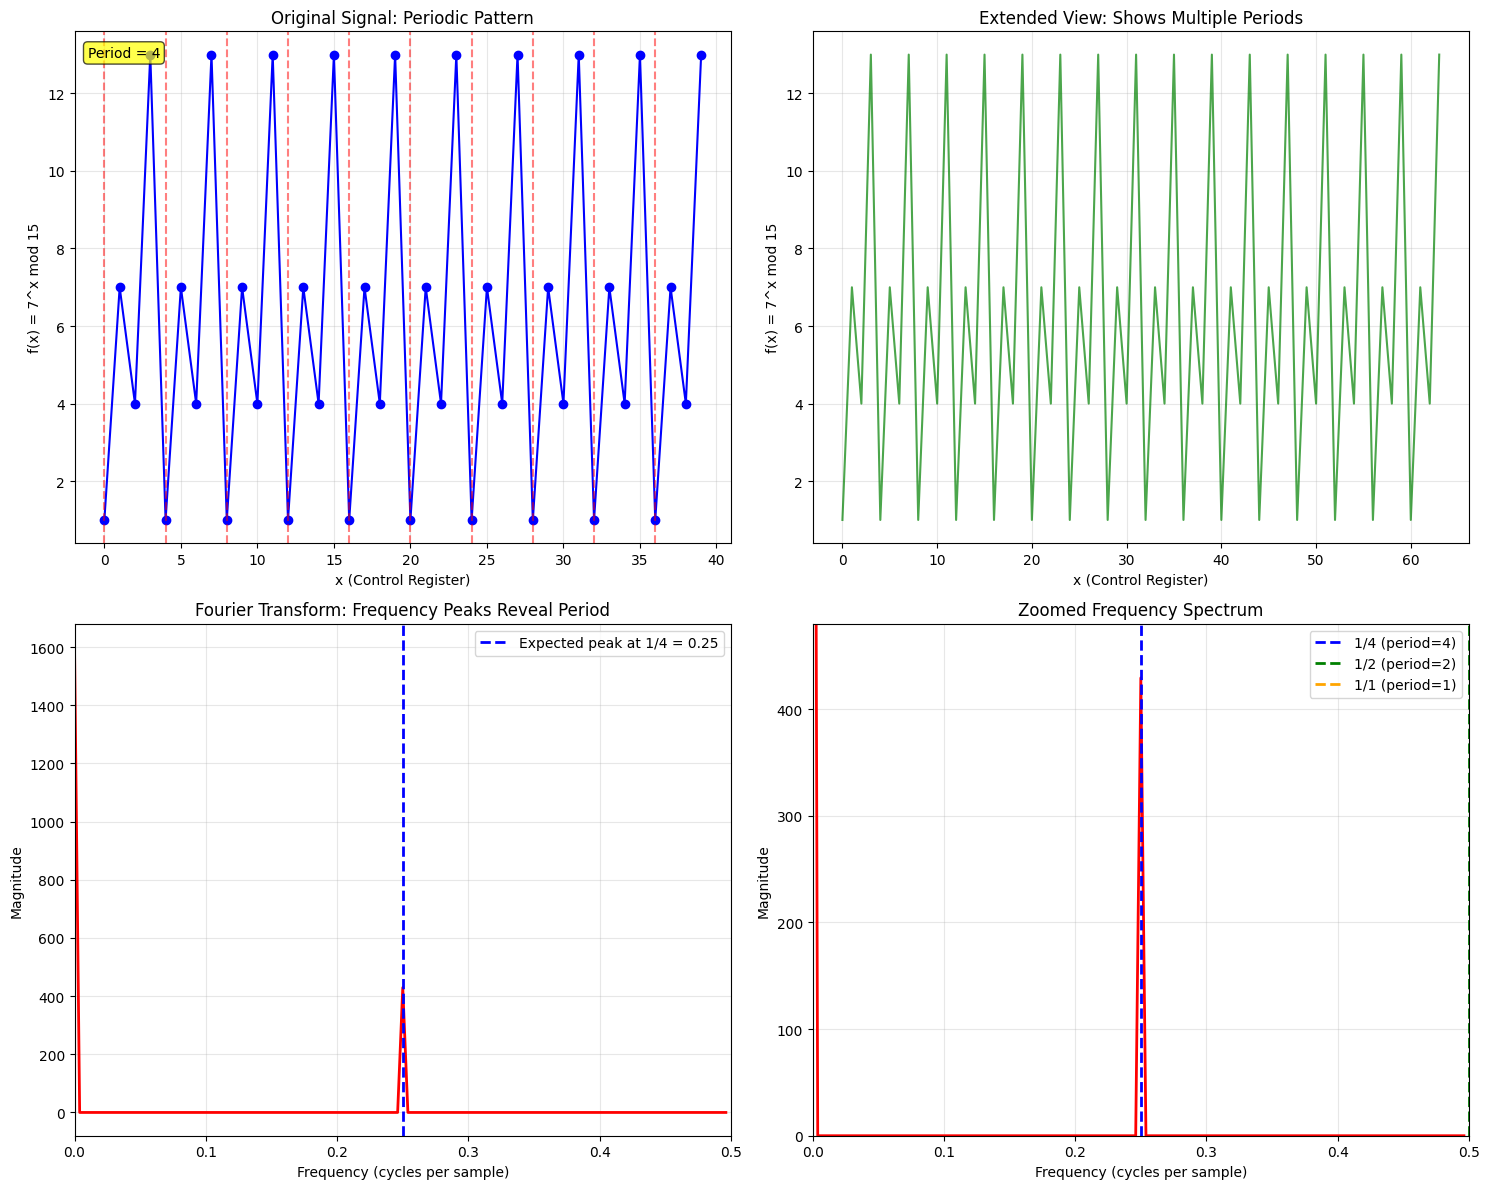

=== FOURIER TRANSFORM ANALYSIS ===
Significant frequency peaks found:
  Frequency: 0.2500 → Period: 4.00 → Magnitude: 429.3

Expected: Frequency = 1/4 = 0.25 (since period = 4)
This corresponds to the order r = 4 in Shor's algorithm


In [9]:
fourier_analysis(output_register, control_register, a=7, N=15)

In [10]:
quantum_fourier_analogy(control_register, output_register)


=== QUANTUM FOURIER TRANSFORM ANALOGY ===

🔍 WHAT WE JUST SAW:
1. Classical FFT detected frequency peaks that reveal the period
2. The peak at frequency 1/4 tells us the period is 4
3. This is exactly what the quantum QFT does!

⚛️  IN THE QUANTUM VERSION:
• Control register is in SUPERPOSITION: (1/√256) Σ |x⟩
• Target register is ENTANGLED: Σ |x⟩|7^x mod 15⟩
• Inverse QFT on control register detects the same frequency peaks
• Measurement gives y-values near multiples of 256/4 = 64

📊 CLASSICAL vs QUANTUM:
CLASSICAL: We computed all 256 values of 7^x mod 15 explicitly
QUANTUM:   All 256 calculations happen simultaneously in superposition!
BOTH:      Use Fourier analysis to find the period r = 4

🎯 THE QUANTUM ADVANTAGE:
• Classical: O(2^n) time to compute all values
• Quantum:  O(n³) time using quantum circuits + QFT
• For large numbers: Exponential speedup!

📏 QUANTUM MEASUREMENT PREDICTIONS:
With 8-qubit control register (0-255), expect peaks near:
  y ≈ 0 (from s=0, y = s×2^m/r = 0